## Generate the dataset

We generate a simple dataset with some gaussian distributions around a few points in the $\mathbb{R}^2$ space. 

We will have 2 classes to predict, represented by the <span style="color:blue">blue</span> $(y = -1)$ and <span style="color:red">red</span> $(y = 1)$ colors.

- $\mathbf{x} \in \mathbb{R}^2$
- $y \in \{-1, 1\}$

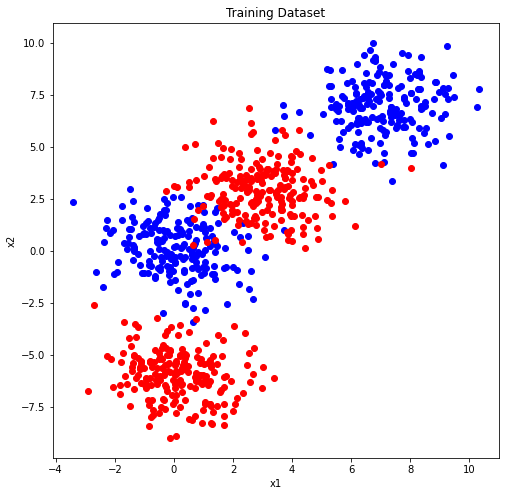

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.utils import shuffle

# Seed for reproducibility
SEED = 1

def gen_data(seed):
    X1, y1 = datasets.make_gaussian_quantiles(cov=1.5,
                                 n_samples=250, n_features=2,
                                 n_classes=1, random_state=seed)
    X2, y2 = datasets.make_gaussian_quantiles(mean=(3, 3), cov=1.5,
                                 n_samples=250, n_features=2,
                                 n_classes=1, random_state=seed+1)
    X3, y3 = datasets.make_gaussian_quantiles(mean=(7, 7), cov=1.5,
                                 n_samples=250, n_features=2,
                                 n_classes=1, random_state=seed+2)
    X4, y4 = datasets.make_gaussian_quantiles(mean=(0, -6), cov=1.5,
                                 n_samples=250, n_features=2,
                                 n_classes=1, random_state=seed+3)
    X = np.concatenate((X1, X2, X3, X4))
    y = np.concatenate((y1, - y2 + 1, y3, -y4 + 1))
    y = 2*y-1
    X, y = shuffle(X, y, random_state=seed)
    return X, y

X,y = gen_data(SEED)
Xtest,X = np.split(X,[200])
ytest,y = np.split(y,[200])

Xblue = X[y==-1]
Xred = X[y==1]
plt.figure(figsize=(8,8))
plt.scatter(Xblue[:,0],Xblue[:,1],c='b')
plt.scatter(Xred[:,0],Xred[:,1],c='r')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Training Dataset')
plt.show()

## Hyper-parameters

### Fitness function

We need to choose a fitness function $f$ to maximize :

$$
\begin{equation}
f(\hat{y}, y) = 4 - \text{MSE}(\hat{y}, y) = 4 - \frac{1}{N}\sum_{i=1}^{N}(\hat{y}_i - y_i)^2 \quad \in \quad [0, 4]
\end{equation}
$$

The Neural Networks with the higher fitness function will be considered as the best candidates during the selection process.

### Configuration file (NEAT)

We will test the NEAT algorithm with the official neat-python library (https://neat-python.readthedocs.io/en/latest/).

First we need to configurate the hyperparameters of the algorithm in a configuration file.

Here are some of the most critical parameters :


#### Network parameters

```python
# network parameters
num_hidden              = 0
num_inputs              = 2
num_outputs             = 1
```

#### Bias and weight initialization

- We **initialize the bias and weights** according to a standard normal distribution $(\mu = 0, \sigma = 1)$.

- We set the **mutate rate** (probability to mutate), and **mutate power** (standard deviation of the mutation) for the bias and weights. 

- We set the **add/remove rates** for the nodes and connections (probability for a node or for an edge to be added/removed)


```python
# node bias options
bias_init_mean          = 0.0  # Standard normal distribution (mu = 0, sigma = 1)
bias_init_stdev         = 1.0
bias_mutate_power       = 0.5  # Standard deviation of the mutation
bias_mutate_rate        = 0.7  # 70% of chance to mutate

# connection weight options
weight_init_mean        = 0.0  # Standard normal distribution (mu = 0, sigma = 1)
weight_init_stdev       = 1.0
weight_mutate_power     = 0.5  # Standard deviation of the mutation
weight_mutate_rate      = 0.8  # 80% of chance to mutate

# node add/remove rates
node_add_prob           = 0.2
node_delete_prob        = 0.2

# connection add/remove rates
conn_add_prob           = 0.5  
conn_delete_prob        = 0.5
````

#### Speciation

```python
[DefaultSpeciesSet]
compatibility_threshold = 3.2

[DefaultStagnation]
species_fitness_func    = max
max_stagnation          = 20
species_elitism         = 2

[DefaultReproduction]
elitism                 = 2
survival_threshold      = 0.2

```

## NEAT Algorithm

In [2]:
from __future__ import print_function
import os
import neat
import visualize
from sklearn.preprocessing import StandardScaler
from IPython.display import display

scaler = StandardScaler()
X_s = scaler.fit_transform(X)
Xtest_s = scaler.transform(Xtest)

n_train = X.shape[0]

def eval_genomes(genomes, config):
    for genome_id, genome in genomes:
        genome.fitness = 4.0
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        for xi, xo in zip(X_s, y):
            output = net.activate((xi[0], xi[1]))
            genome.fitness -= (1 / n_train) * (output[0] - xo) ** 2


def run(config_file, n_gen):
    # Load configuration.
    config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation,
                         config_file)

    # Create the population, which is the top-level object for a NEAT run.
    p = neat.Population(config)

    # Add a stdout reporter to show progress in the terminal.
    p.add_reporter(neat.StdOutReporter(True))
    stats = neat.StatisticsReporter()
    p.add_reporter(stats)
    p.add_reporter(neat.Checkpointer(5, filename_prefix='./checkpoints/neat-checkpoint-'))

    # Run for up to n_gen generations.
    winner = p.run(eval_genomes, n_gen)

    return winner, config, stats


## Training on 150 generations

In [3]:
import random

random.seed(SEED)

local_dir = os.path.dirname('')

# Config file path
config_path = os.path.join(local_dir, 'config-feedforward-gaussian')

# Run the training
winner, config, stats = run(config_path, n_gen = 150)
winner_net = neat.nn.FeedForwardNetwork.create(winner, config)


 ****** Running generation 0 ****** 

Population's average fitness: 2.18980 stdev: 0.48243
Best fitness: 3.13103 - size: (1, 2) - species 1 - id 57
Average adjusted fitness: 0.534
Mean genetic distance 1.253, standard deviation 0.468
Population of 300 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0   300      3.1    0.534     0
Total extinctions: 0
Generation time: 2.191 sec

 ****** Running generation 1 ****** 

Population's average fitness: 2.57463 stdev: 0.39861
Best fitness: 3.27237 - size: (2, 3) - species 1 - id 304
Average adjusted fitness: 0.664
Mean genetic distance 1.402, standard deviation 0.439
Population of 300 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    1   300      3.3    0.664     0
Total extinctions: 0
Generation time: 2.111 sec (2.151 average)

 ****** Running generation 2 ****** 

Population's average fitness: 2.64251 stdev: 0

Population's average fitness: 2.75753 stdev: 0.43515
Best fitness: 3.48474 - size: (3, 4) - species 1 - id 4945
Average adjusted fitness: 0.680
Mean genetic distance 1.838, standard deviation 0.633
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   16   100      3.5    0.675     0
     2   12    93      3.2    0.700     2
     3   11   107      3.3    0.666    10
Total extinctions: 0
Generation time: 2.311 sec (1.834 average)

 ****** Running generation 17 ****** 

Population's average fitness: 2.77813 stdev: 0.43655
Best fitness: 3.57185 - size: (3, 4) - species 1 - id 5312
Average adjusted fitness: 0.661
Mean genetic distance 1.843, standard deviation 0.582
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   17   100      3.6    0.602     0
     2   13    87      3.3    0.707     0
     3   12   114      3.3    0.674    11


Population's average fitness: 2.77767 stdev: 0.44382
Best fitness: 3.67751 - size: (4, 7) - species 1 - id 7667
Average adjusted fitness: 0.665
Mean genetic distance 1.991, standard deviation 0.223
Population of 299 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   31   102      3.7    0.689     6
     2   27    97      3.5    0.664     2
     3   26   100      3.6    0.643     2
Total extinctions: 0
Generation time: 2.709 sec (2.190 average)

 ****** Running generation 32 ****** 

Population's average fitness: 2.79529 stdev: 0.47447
Best fitness: 3.67751 - size: (4, 7) - species 1 - id 7667
Average adjusted fitness: 0.662
Mean genetic distance 1.922, standard deviation 0.270
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   32   147      3.7    0.701     7
     2   28    67      3.6    0.654     3
     3   27    86      3.7    0.631     0


Population's average fitness: 2.91215 stdev: 0.56612
Best fitness: 3.80722 - size: (4, 6) - species 4 - id 13793
Average adjusted fitness: 0.669
Mean genetic distance 2.307, standard deviation 0.512
Population of 301 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   46   106      3.8    0.643     3
     2   42    34      3.0    0.697     8
     3   41    58      3.3    0.644     6
     4    3   103      3.8    0.691     0
Total extinctions: 0
Generation time: 2.634 sec (2.684 average)

 ****** Running generation 47 ****** 

Population's average fitness: 2.91697 stdev: 0.53718
Best fitness: 3.83655 - size: (5, 8) - species 4 - id 14096
Average adjusted fitness: 0.642
Mean genetic distance 2.306, standard deviation 0.515
Population of 300 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   47    57      3.8    0.655     4
     2   43    90      3.0    0.632     

Population's average fitness: 2.97359 stdev: 0.65861
Best fitness: 3.86596 - size: (7, 12) - species 4 - id 16899
Average adjusted fitness: 0.670
Mean genetic distance 2.052, standard deviation 0.480
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   60    87      3.8    0.671     6
     3   55    44      3.8    0.661     4
     4   17   169      3.9    0.677     3
Total extinctions: 0
Generation time: 2.749 sec (2.711 average)

 ****** Running generation 61 ****** 

Population's average fitness: 2.97553 stdev: 0.61850
Best fitness: 3.86596 - size: (7, 12) - species 4 - id 16899
Average adjusted fitness: 0.632
Mean genetic distance 2.236, standard deviation 0.513
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   61    94      3.8    0.620     7
     3   56    28      3.7    0.581     5
     4   18   179      3.9    0.696   

Population's average fitness: 3.08353 stdev: 0.67690
Best fitness: 3.88368 - size: (8, 12) - species 4 - id 20289
Average adjusted fitness: 0.704
Mean genetic distance 2.606, standard deviation 0.536
Population of 299 members in 6 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   74    16      3.7    0.645     7
     3   69    60      3.8    0.708     4
     4   31    62      3.9    0.736     6
     5    4    49      3.9    0.734     2
     6    2    29      3.9    0.692     0
     7    2    83      3.9    0.710     0
Total extinctions: 0
Generation time: 2.956 sec (2.982 average)
Saving checkpoint to ./checkpoints/neat-checkpoint-74

 ****** Running generation 75 ****** 

Population's average fitness: 3.02883 stdev: 0.68077
Best fitness: 3.88368 - size: (8, 12) - species 4 - id 20289
Average adjusted fitness: 0.654
Mean genetic distance 2.559, standard deviation 0.568
Population of 299 members in 6 species:
   ID   age  size  fitness

Population's average fitness: 3.06435 stdev: 0.69320
Best fitness: 3.89005 - size: (8, 10) - species 5 - id 22551
Average adjusted fitness: 0.647
Mean genetic distance 2.539, standard deviation 0.597
Population of 302 members in 7 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   86    41      3.8    0.665     4
     3   81    39      3.8    0.594    16
     4   43    41      3.9    0.651    18
     5   16    45      3.9    0.673    10
     6   14    46      3.9    0.696     8
     7   14    43      3.9    0.638     1
     8    4    47      3.9    0.613     2
Total extinctions: 0
Generation time: 3.088 sec (3.036 average)

 ****** Running generation 87 ****** 

Population's average fitness: 3.15106 stdev: 0.65162
Best fitness: 3.89005 - size: (8, 10) - species 5 - id 22551
Average adjusted fitness: 0.673
Mean genetic distance 2.585, standard deviation 0.581
Population of 301 members in 7 species:
   ID   age  size  fitness  adj fit  s

Population's average fitness: 3.04330 stdev: 0.73306
Best fitness: 3.89079 - size: (7, 10) - species 5 - id 26024
Average adjusted fitness: 0.694
Mean genetic distance 2.404, standard deviation 0.671
Population of 300 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   99    72      3.8    0.663    17
     5   29    78      3.9    0.685    11
     7   27    72      3.9    0.693    14
     8   17    78      3.9    0.734     0
Total extinctions: 0
Generation time: 2.944 sec (3.057 average)
Saving checkpoint to ./checkpoints/neat-checkpoint-99

 ****** Running generation 100 ****** 

Population's average fitness: 3.13391 stdev: 0.69226
Best fitness: 3.89079 - size: (7, 10) - species 5 - id 26024
Average adjusted fitness: 0.709
Mean genetic distance 2.474, standard deviation 0.638
Population of 300 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  100    71      3.

Population's average fitness: 3.11318 stdev: 0.67439
Best fitness: 3.89310 - size: (7, 10) - species 5 - id 31284
Average adjusted fitness: 0.710
Mean genetic distance 2.287, standard deviation 0.544
Population of 299 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     5   43    80      3.9    0.751     7
     7   41    78      3.9    0.712     2
     8   31    80      3.9    0.684     9
     9    7    61      3.9    0.691     2
Total extinctions: 0
Generation time: 2.912 sec (2.980 average)

 ****** Running generation 114 ****** 

Population's average fitness: 3.10852 stdev: 0.72152
Best fitness: 3.89310 - size: (7, 10) - species 5 - id 31284
Average adjusted fitness: 0.716
Mean genetic distance 2.351, standard deviation 0.535
Population of 300 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     5   44    81      3.9    0.751     8
     7   42    93      3.9    0.745  

Population's average fitness: 3.07631 stdev: 0.72647
Best fitness: 3.89310 - size: (7, 10) - species 5 - id 31284
Average adjusted fitness: 0.700
Mean genetic distance 2.627, standard deviation 0.579
Population of 301 members in 6 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     5   57    57      3.9    0.752    21
     7   55    55      3.9    0.691     8
     8   45    55      3.9    0.690     9
     9   21    52      3.9    0.636     6
    10    7    31      3.9    0.788     2
    11    1    51      3.8    0.645     0
Total extinctions: 0
Generation time: 2.872 sec (2.894 average)

 ****** Running generation 128 ****** 

Population's average fitness: 3.10245 stdev: 0.72354
Best fitness: 3.89310 - size: (7, 10) - species 5 - id 31284
Average adjusted fitness: 0.685
Mean genetic distance 2.585, standard deviation 0.565
Population of 300 members in 6 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  

Population's average fitness: 3.08257 stdev: 0.72196
Best fitness: 3.89310 - size: (7, 10) - species 5 - id 31284

Species 7 with 49 members is stagnated: removing it
Average adjusted fitness: 0.650
Mean genetic distance 2.444, standard deviation 0.617
Population of 300 members in 5 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     5   69    60      3.9    0.618    33
     9   33    62      3.9    0.687    18
    10   19    60      3.9    0.677     6
    11   13    63      3.9    0.674     4
    12   10    55      3.9    0.595     5
Total extinctions: 0
Generation time: 3.106 sec (3.033 average)
Saving checkpoint to ./checkpoints/neat-checkpoint-139

 ****** Running generation 140 ****** 

Population's average fitness: 3.10244 stdev: 0.69922
Best fitness: 3.89310 - size: (7, 10) - species 5 - id 31284
Average adjusted fitness: 0.718
Mean genetic distance 2.440, standard deviation 0.590
Population of 300 members in 5 species:
   ID   age  

## Results

### Stats and winning network graph

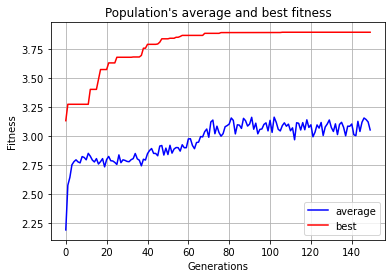

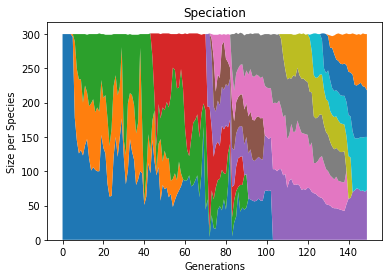


Best genome:
Key: 31284
Fitness: 3.8930992557684894
Nodes:
	0 DefaultNodeGene(key=0, bias=0.23400858256615942, response=1.0, activation=tanh, aggregation=sum)
	361 DefaultNodeGene(key=361, bias=0.17859340851613492, response=1.0, activation=tanh, aggregation=sum)
	3074 DefaultNodeGene(key=3074, bias=-2.45629119487256, response=1.0, activation=tanh, aggregation=sum)
	4301 DefaultNodeGene(key=4301, bias=-0.9959788249888539, response=1.0, activation=tanh, aggregation=sum)
	5091 DefaultNodeGene(key=5091, bias=0.7697573023682914, response=1.0, activation=tanh, aggregation=sum)
	5391 DefaultNodeGene(key=5391, bias=0.5457253907282743, response=1.0, activation=tanh, aggregation=sum)
	5787 DefaultNodeGene(key=5787, bias=-0.4696307289715335, response=1.0, activation=tanh, aggregation=sum)
Connections:
	DefaultConnectionGene(key=(-2, 0), weight=-7.242003830077677, enabled=True)
	DefaultConnectionGene(key=(-2, 361), weight=4.760880488751987, enabled=True)
	DefaultConnectionGene(key=(-2, 3074), wei

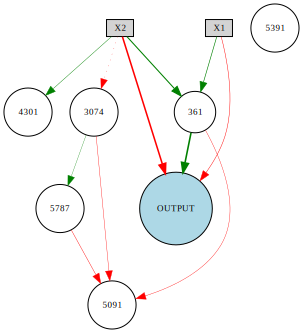

In [4]:
def plot_results (winner, config, stats):
    node_names = {-1:'X1', -2: 'X2', 0:'OUTPUT'}
    
    # Plot stats and speciation
    visualize.plot_stats(stats, ylog=False, view=True, filename='./visualization/avg_fitness.svg')
    visualize.plot_species(stats, view=True, filename='./visualization/speciation.svg')
    
    # Display the winning genome.
    print('\nBest genome:\n{!s}'.format(winner))
    dot = visualize.draw_net(config, winner, False, node_names=node_names, filename='./visualization/graph', 
                             fmt='svg')
    # Plot the graph
    display(dot)


# Plot the results
plot_results(winner, config, stats)

### Predictions

#### Predictions on test dataset

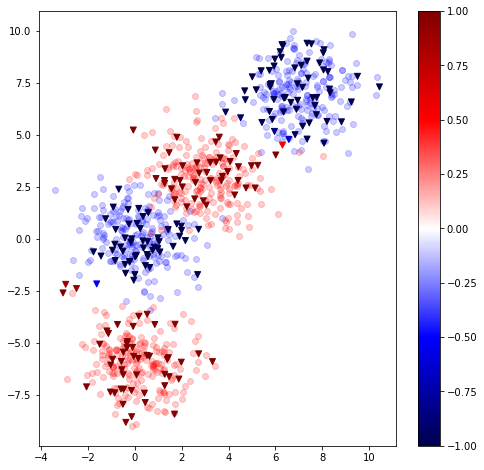

In [5]:
pred = np.array([winner_net.activate(x) for x in Xtest_s])

Xblue = X[y==-1]
Xred = X[y==1]
plt.figure(figsize=(8,8))
plt.scatter(Xblue[:,0],Xblue[:,1],c='b', alpha=0.2)
plt.scatter(Xred[:,0],Xred[:,1],c='r', alpha=0.2)
plt.scatter(Xtest[:, 0], Xtest[:, 1], marker='v', c=pred, cmap='seismic')
plt.colorbar()
plt.show()


#### Decision function of the winning network

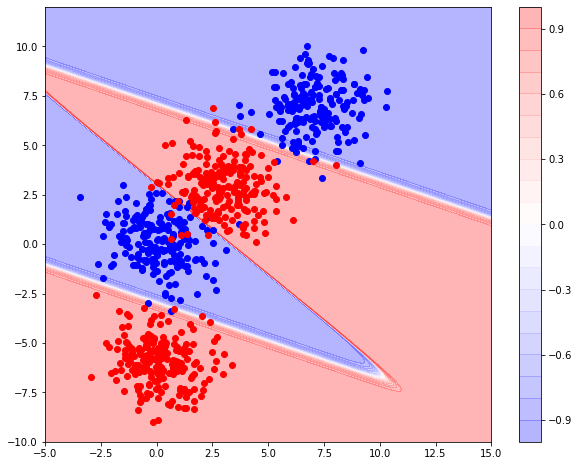

In [6]:
XX = np.linspace(-5, 15, 500)
YY = np.linspace(-10, 12, 500)
XX, YY = np.meshgrid(XX, YY)

f = np.vectorize(lambda x, y: winner_net.activate((x, y)))
ZZ = np.array([winner_net.activate(scaler.transform([[x, y]])[0]) 
               for x, y in zip(XX.ravel(), YY.ravel())]).reshape(XX.shape)

plt.figure(figsize=(10, 8))
plt.contourf(XX, YY, ZZ, cmap='bwr', alpha=0.3, levels=20)
plt.colorbar()
plt.scatter(Xblue[:,0],Xblue[:,1],c='b')
plt.scatter(Xred[:,0],Xred[:,1],c='r')
plt.show()
